## Beam Dyanimcs

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import mineut
from mineut import plot_tools as pt
from mineut import lattice_tools as lt

from mineut.MuC import MuDecaySimulator

In [4]:

RLA2_numu = MuDecaySimulator(
    muon_polarization=0.0,
    nuflavor='numu',
    direction="right",
    n_evals=1e6,
    )

RLA2_nue = MuDecaySimulator(
    muon_polarization=0.0,
    nuflavor='nue',
    direction="right",
    n_evals=1e6,
    )

RLA2_numu.decay_muons()
RLA2_nue.decay_muons()

[ 2157.68        2160.60501144  2163.53002288 ... 17587.56156373
 17590.48657517 17593.4115866 ]
Setting additional z to <scipy.interpolate._interpolate.interp1d object at 0x1273c2b20>
Setting additional tangent to <function create_lattice_dict_from_vertices.<locals>.<lambda> at 0x1273853a0>
Setting additional beamdiv to 0.001
Setting additional beamsize to 0.01
Warning! The following keys were not recognized and will be ignored: dict_keys(['z', 'tangent', 'beamdiv', 'beamsize'])


/Users/jchoi55/Documents/GitHub/MINeut/mineut/lattice_tools.py:561: RuntimeWarning: divide by zero encountered in divide
  beamdiv = np.where(beta < 1.0, beta, np.sqrt(emittance / beta))


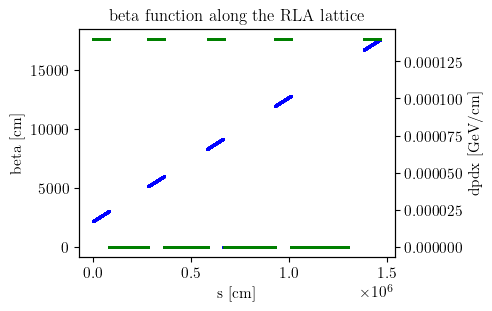

In [5]:
RLA2_lattice = lt.create_RLA_lattice(
            name = r"RLA2",
            short_name= "rla2",
            straight_length=829e2,
            n_elements=100_000,
            p0_injection=5.0,
            dp_dx_LA=11.6/829e2,
            beamdiv=1e-3,
            beamdiv_z=1e-2,
            beamsize=1e-2,
            half=False,
            Nmu_per_bunch=2e12,
)

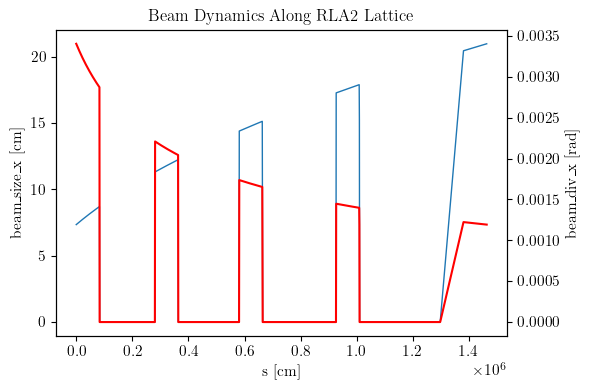

In [30]:
# u ranges from 0 → 1
u_vals = np.linspace(0, 1, 2000)

# Convert to actual s-position (in cm):
s_vals = u_vals * 1463126.8482550883   # or lattice.length

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(s_vals, RLA2_lattice.beamsize_x(u_vals), linewidth=1.0)

ax2 = ax.twinx()
ax2.plot(s_vals, RLA2_lattice.beamdiv_x(u_vals), color="red")

ax.set_xlabel("s [cm]")
ax.set_ylabel("beam_size_x [cm]")
ax2.set_ylabel("beam_div_x [rad]")
ax.set_title("Beam Dynamics Along RLA2 Lattice")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'RLA 2')

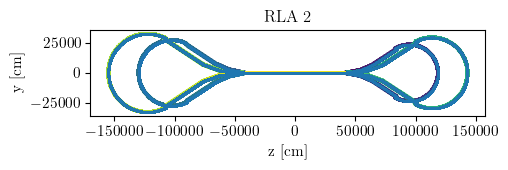

In [7]:
RLA2_nue.place_muons_on_lattice(lattice=RLA2_lattice, direction="clockwise")
RLA2_numu.place_muons_on_lattice(lattice=RLA2_lattice, direction="clockwise")

max_index = len(RLA2_lattice.vertices[1])

fig, ax = pt.std_fig(figsize=(5, 2))
ax.scatter(RLA2_lattice.vertices[0], RLA2_lattice.vertices[1], c=np.linspace(0, 1, max_index), marker='+', s=10)
ax.scatter(RLA2_numu.pos['z'], RLA2_numu.pos['x'], marker='.', s=0.25)

fig.gca().set_aspect('equal', adjustable='box')

ax.set_xlabel("z [cm]")
ax.set_ylabel("y [cm]")
ax.set_title("RLA 2")

In [8]:
def plot_avgE_vs_time(MuC_acc_numu, MuC_acc_nue):
    # Bin mutimes and compute average neutrino energy in each bin
    bins = np.linspace(MuC_acc_numu.mutimes.min(), MuC_acc_numu.mutimes.max(), 50)
    digitized = np.digitize(MuC_acc_numu.mutimes, bins)
    avg_mu_E = [MuC_acc_numu.pmu['E'][digitized == i].mean() if np.any(digitized == i) else np.nan for i in range(1, len(bins))]
    avg_numu_E = [MuC_acc_numu.pnu['E'][digitized == i].mean() if np.any(digitized == i) else np.nan for i in range(1, len(bins))]
    bins = np.linspace(MuC_acc_nue.mutimes.min(), MuC_acc_nue.mutimes.max(), 50)
    digitized = np.digitize(MuC_acc_nue.mutimes, bins)
    avg_nue_E = [MuC_acc_nue.pnu['E'][digitized == i].mean() if np.any(digitized == i) else np.nan for i in range(1, len(bins))]

    fig, ax = pt.std_fig(figsize=(4,3))
    ax.step(1e6*bins[:-1], avg_mu_E, linestyle='-', color='grey', label=r'$\langle E_{\mu} \rangle$')
    ax.step(1e6*bins[:-1], avg_nue_E, linestyle='-', color='darkorange', label=r'$\langle E_{\nu_e} \rangle$')
    ax.step(1e6*bins[:-1], avg_numu_E, linestyle='-', color='dodgerblue', label=r'$\langle E_{\nu_\mu} \rangle$')
    ax.set_xlabel('time ($\mu$s)')
    ax.set_ylabel(r'Average neutrino energy [GeV]')
    ax.legend(frameon=False, loc='upper left')
    return fig, ax

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='time ($\\mu$s)', ylabel='Average neutrino energy [GeV]'>)

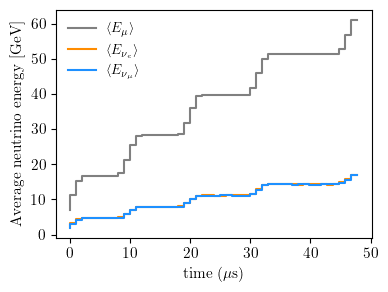

In [9]:
plot_avgE_vs_time(RLA2_numu, RLA2_nue)

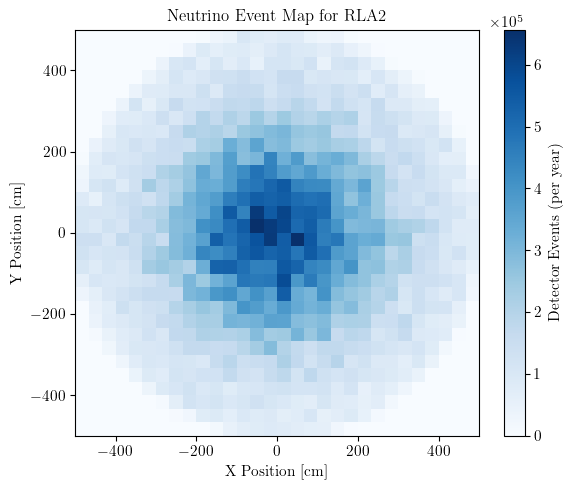

In [10]:
X, Y, event_map = RLA2_numu.get_event_map_fixed_z(
    detect_loc=[(1500e2, 0)],
    xrange=(-500,500),  
    yrange=(-500, 500),      
    nx=30,
    ny=30,
    det_radius=5e2              # 10m detector
)


import matplotlib.ticker as ticker

plt.figure(figsize=(6, 5))
c = plt.pcolormesh(X, Y, event_map.T, shading='auto', cmap='Blues', vmin=1e-10)
cb = plt.colorbar(c, label='Detector Events (per year)')

# Force scientific notation on the colorbar
cb.formatter = ticker.ScalarFormatter()
cb.formatter.set_powerlimits((-2, 2))   # scientific notation outside [-2, 2]
cb.update_ticks()

plt.xlabel('X Position [cm]')
plt.ylabel('Y Position [cm]')
plt.title("Neutrino Event Map for RLA2")
plt.tight_layout()
plt.show()

annotate the TOTAL NUM of events

## Racetrack RLA Design

In [18]:
racetrack_RLA_numu = MuDecaySimulator(
    muon_polarization=0.0,
    nuflavor='numu',
    direction="right",
    n_evals=1e6,
    )

racetrack_RLA_numu.decay_muons()

In [15]:
racetrack_RLA_data=np.array([[-1.763e+4, -5.846e+3],
[-1.747e+4, -5.556e+3],
[-1.752e+4, -5.261e+3],
[-1.731e+4, -4.987e+3],
[-1.734e+4, -4.738e+3],
[-1.711e+4, -4.297e+3],
[-1.691e+4, -3.921e+3],
[-1.682e+4, -3.641e+3],
[-1.661e+4, -3.361e+3],
[-1.650e+4, -3.089e+3],
[-1.632e+4, -2.829e+3],
[-1.601e+4, -2.513e+3],
[-1.567e+4, -2.152e+3],
[-1.532e+4, -1.823e+3],
[-1.503e+4, -1.565e+3],
[-1.462e+4, -1.318e+3],
[-1.434e+4, -1.068e+3],
[-1.384e+4, -8.064e+2],
[-1.328e+4, -5.573e+2],
[-1.261e+4, -3.406e+2],
[-1.168e+4, -9.899e+1],
[-1.069e+4, -1.352e+1],
[-9.697e+3, -8.668e+0],
[-8.706e+3, -8.668e+0],
[-7.715e+3, -8.668e+0],
[-6.723e+3, -8.668e+0],
[-5.732e+3, -8.668e+0],
[-4.741e+3, -8.668e+0],
[-3.750e+3, -8.668e+0],
[-2.758e+3, -8.668e+0],
[-1.767e+3, -8.668e+0],
[-7.755e+2, -8.668e+0],
[2.158e+2, -8.668e+0],
[1.207e+3, -8.668e+0],
[2.198e+3, -8.668e+0],
[3.190e+3, -8.668e+0],
[4.181e+3, -8.668e+0],
[5.172e+3, -8.668e+0],
[6.164e+3, -8.668e+0],
[7.155e+3, -8.668e+0],
[8.146e+3, -8.668e+0],
[9.138e+3, -8.668e+0],
[1.013e+4, -8.668e+0],
[1.112e+4, -8.668e+0],
[1.211e+4, -8.668e+0],
[1.310e+4, -8.668e+0],
[1.409e+4, -8.668e+0],
[1.509e+4, -8.668e+0],
[1.608e+4, -8.668e+0],
[1.707e+4, -8.668e+0],
[1.806e+4, -8.668e+0],
[1.905e+4, -8.668e+0],
[2.004e+4, -8.668e+0],
[2.103e+4, -8.668e+0],
[2.202e+4, -8.668e+0],
[2.302e+4, -8.668e+0],
[2.401e+4, -8.668e+0],
[2.500e+4, -8.668e+0],
[2.599e+4, -8.668e+0],
[2.698e+4, -8.668e+0],
[2.797e+4, -8.668e+0],
[2.896e+4, -8.668e+0],
[2.996e+4, -8.668e+0],
[3.095e+4, -8.668e+0],
[3.194e+4, -8.668e+0],
[3.293e+4, -8.668e+0],
[3.392e+4, -8.668e+0],
[3.491e+4, -8.668e+0],
[3.590e+4, -8.668e+0],
[3.689e+4, -8.668e+0],
[3.789e+4, -8.668e+0],
[3.888e+4, -8.668e+0],
[3.987e+4, -8.668e+0],
[4.086e+4, -8.668e+0],
[4.185e+4, -8.668e+0],
[4.284e+4, -8.668e+0],
[4.383e+4, -8.668e+0],
[4.483e+4, -8.668e+0],
[4.582e+4, -8.668e+0],
[4.681e+4, -8.668e+0],
[4.780e+4, -8.668e+0],
[4.879e+4, -8.668e+0],
[4.978e+4, -8.668e+0],
[5.077e+4, -8.668e+0],
[5.176e+4, -8.668e+0],
[5.276e+4, -8.668e+0],
[5.375e+4, -8.668e+0],
[5.474e+4, -8.668e+0],
[5.573e+4, -8.668e+0],
[5.672e+4, -8.668e+0],
[5.771e+4, -8.668e+0],
[5.870e+4, -8.668e+0],
[5.970e+4, -8.668e+0],
[6.069e+4, -8.668e+0],
[6.168e+4, -8.668e+0],
[6.267e+4, -8.668e+0],
[6.366e+4, -8.668e+0],
[6.465e+4, -8.668e+0],
[6.564e+4, -1.255e+1],
[6.663e+4, -1.935e+1],
[6.763e+4, -1.935e+1],
[6.862e+4, -1.935e+1],
[6.961e+4, -1.935e+1],
[7.060e+4, -1.935e+1],
[7.159e+4, -1.935e+1],
[7.258e+4, -1.935e+1],
[7.357e+4, -1.935e+1],
[7.456e+4, -1.935e+1],
[7.556e+4, -1.935e+1],
[7.655e+4, -1.935e+1],
[7.754e+4, -1.935e+1],
[7.853e+4, -1.935e+1],
[7.952e+4, -1.935e+1],
[8.051e+4, -1.935e+1],
[8.150e+4, -1.935e+1],
[8.250e+4, -1.935e+1],
[8.349e+4, -1.935e+1],
[8.448e+4, -1.935e+1],
[8.547e+4, -1.935e+1],
[8.646e+4, -1.935e+1],
[8.745e+4, -1.935e+1],
[8.844e+4, -1.935e+1],
[8.943e+4, -1.935e+1],
[9.043e+4, -1.935e+1],
[9.142e+4, -1.935e+1],
[9.241e+4, -1.935e+1],
[9.340e+4, -1.935e+1],
[9.439e+4, -1.935e+1],
[9.538e+4, -1.935e+1],
[9.637e+4, -1.935e+1],
[9.737e+4, -1.935e+1],
[9.836e+4, -1.935e+1],
[9.935e+4, -1.935e+1],
[1.003e+5, -1.935e+1],
[1.013e+5, -1.935e+1],
[1.023e+5, -8.539e+1],
[1.033e+5, -2.748e+2],
[1.037e+5, -4.754e+2],
[1.043e+5, -6.834e+2],
[1.049e+5, -9.420e+2],
[1.053e+5, -1.206e+3],
[1.055e+5, -1.419e+3],
[1.059e+5, -1.681e+3],
[1.062e+5, -1.965e+3],
[1.065e+5, -2.241e+3],
[1.068e+5, -2.515e+3],
[1.070e+5, -2.834e+3],
[1.073e+5, -3.191e+3],
[1.075e+5, -3.513e+3],
[1.076e+5, -3.759e+3],
[1.077e+5, -4.008e+3],
[1.079e+5, -4.255e+3],
[1.080e+5, -4.530e+3],
[1.080e+5, -4.753e+3],
[1.082e+5, -5.004e+3],
[1.082e+5, -5.256e+3],
[1.084e+5, -5.539e+3],
[1.084e+5, -5.797e+3],
[1.083e+5, -6.040e+3],
[1.084e+5, -6.293e+3],
[1.085e+5, -6.571e+3],
[1.085e+5, -6.819e+3],
[1.085e+5, -7.054e+3],
[1.085e+5, -7.289e+3],
[1.085e+5, -7.524e+3],
[1.085e+5, -7.679e+3],
[1.084e+5, -7.950e+3],
[1.084e+5, -8.289e+3],
[1.084e+5, -8.494e+3],
[1.082e+5, -8.833e+3],
[1.082e+5, -9.104e+3],
[1.080e+5, -9.372e+3],
[1.079e+5, -9.728e+3],
[1.078e+5, -1.005e+4],
[1.076e+5, -1.035e+4],
[1.074e+5, -1.066e+4],
[1.072e+5, -1.094e+4],
[1.071e+5, -1.121e+4],
[1.068e+5, -1.155e+4],
[1.064e+5, -1.189e+4],
[1.062e+5, -1.218e+4],
[1.058e+5, -1.244e+4],
[1.055e+5, -1.270e+4],
[1.052e+5, -1.297e+4],
[1.047e+5, -1.321e+4],
[1.040e+5, -1.351e+4],
[1.033e+5, -1.377e+4],
[1.023e+5, -1.392e+4],
[1.013e+5, -1.399e+4],
[1.003e+5, -1.399e+4],
[9.935e+4, -1.399e+4],
[9.836e+4, -1.399e+4],
[9.737e+4, -1.399e+4],
[9.637e+4, -1.399e+4],
[9.538e+4, -1.399e+4],
[9.439e+4, -1.399e+4],
[9.340e+4, -1.399e+4],
[9.241e+4, -1.399e+4],
[9.142e+4, -1.399e+4],
[9.043e+4, -1.399e+4],
[8.943e+4, -1.399e+4],
[8.844e+4, -1.399e+4],
[8.745e+4, -1.399e+4],
[8.646e+4, -1.399e+4],
[8.547e+4, -1.399e+4],
[8.448e+4, -1.399e+4],
[8.349e+4, -1.399e+4],
[8.250e+4, -1.399e+4],
[8.150e+4, -1.399e+4],
[8.051e+4, -1.399e+4],
[7.952e+4, -1.399e+4],
[7.853e+4, -1.399e+4],
[7.754e+4, -1.399e+4],
[7.655e+4, -1.399e+4],
[7.556e+4, -1.399e+4],
[7.456e+4, -1.399e+4],
[7.357e+4, -1.399e+4],
[7.258e+4, -1.399e+4],
[7.159e+4, -1.399e+4],
[7.060e+4, -1.399e+4],
[6.961e+4, -1.399e+4],
[6.862e+4, -1.399e+4],
[6.763e+4, -1.399e+4],
[6.663e+4, -1.399e+4],
[6.564e+4, -1.399e+4],
[6.465e+4, -1.399e+4],
[6.366e+4, -1.399e+4],
[6.267e+4, -1.399e+4],
[6.168e+4, -1.399e+4],
[6.069e+4, -1.399e+4],
[5.970e+4, -1.399e+4],
[5.870e+4, -1.399e+4],
[5.771e+4, -1.399e+4],
[5.672e+4, -1.399e+4],
[5.573e+4, -1.399e+4],
[5.474e+4, -1.399e+4],
[5.375e+4, -1.399e+4],
[5.276e+4, -1.399e+4],
[5.176e+4, -1.399e+4],
[5.077e+4, -1.399e+4],
[4.978e+4, -1.399e+4],
[4.879e+4, -1.399e+4],
[4.780e+4, -1.399e+4],
[4.681e+4, -1.399e+4],
[4.582e+4, -1.399e+4],
[4.483e+4, -1.399e+4],
[4.383e+4, -1.399e+4],
[4.284e+4, -1.399e+4],
[4.185e+4, -1.399e+4],
[4.086e+4, -1.399e+4],
[3.987e+4, -1.399e+4],
[3.888e+4, -1.399e+4],
[3.789e+4, -1.399e+4],
[3.689e+4, -1.399e+4],
[3.590e+4, -1.399e+4],
[3.491e+4, -1.399e+4],
[3.392e+4, -1.399e+4],
[3.293e+4, -1.399e+4],
[3.194e+4, -1.399e+4],
[3.095e+4, -1.399e+4],
[2.996e+4, -1.399e+4],
[2.896e+4, -1.398e+4],
[2.797e+4, -1.398e+4],
[2.698e+4, -1.398e+4],
[2.599e+4, -1.398e+4],
[2.500e+4, -1.398e+4],
[2.401e+4, -1.398e+4],
[2.302e+4, -1.398e+4],
[2.202e+4, -1.398e+4],
[2.103e+4, -1.398e+4],
[2.004e+4, -1.398e+4],
[1.905e+4, -1.398e+4],
[1.806e+4, -1.398e+4],
[1.707e+4, -1.398e+4],
[1.608e+4, -1.398e+4],
[1.509e+4, -1.398e+4],
[1.409e+4, -1.398e+4],
[1.310e+4, -1.398e+4],
[1.211e+4, -1.398e+4],
[1.112e+4, -1.398e+4],
[1.013e+4, -1.398e+4],
[9.138e+3, -1.398e+4],
[8.146e+3, -1.398e+4],
[7.155e+3, -1.398e+4],
[6.164e+3, -1.398e+4],
[5.172e+3, -1.398e+4],
[4.181e+3, -1.398e+4],
[3.190e+3, -1.398e+4],
[2.198e+3, -1.398e+4],
[1.207e+3, -1.398e+4],
[2.158e+2, -1.398e+4],
[-7.755e+2, -1.398e+4],
[-1.767e+3, -1.398e+4],
[-2.758e+3, -1.398e+4],
[-3.750e+3, -1.398e+4],
[-4.741e+3, -1.398e+4],
[-5.732e+3, -1.398e+4],
[-6.723e+3, -1.398e+4],
[-7.715e+3, -1.398e+4],
[-8.706e+3, -1.398e+4],
[-9.697e+3, -1.398e+4],
[-1.069e+4, -1.398e+4],
[-1.168e+4, -1.390e+4],
[-1.266e+4, -1.373e+4],
[-1.334e+4, -1.347e+4],
[-1.393e+4, -1.322e+4],
[-1.432e+4, -1.301e+4],
[-1.468e+4, -1.273e+4],
[-1.518e+4, -1.239e+4],
[-1.558e+4, -1.206e+4],
[-1.584e+4, -1.176e+4],
[-1.614e+4, -1.146e+4],
[-1.631e+4, -1.116e+4],
[-1.660e+4, -1.084e+4],
[-1.677e+4, -1.056e+4],
[-1.693e+4, -1.024e+4],
[-1.703e+4, -9.929e+3],
[-1.723e+4, -9.588e+3],
[-1.736e+4, -9.218e+3],
[-1.754e+4, -8.864e+3],
[-1.754e+4, -8.641e+3],
[-1.758e+4, -8.368e+3],
[-1.771e+4, -8.072e+3],
[-1.767e+4, -7.826e+3],
[-1.767e+4, -7.591e+3],
[-1.767e+4, -7.356e+3],
[-1.767e+4, -7.121e+3],
[-1.767e+4, -6.886e+3],
[-1.767e+4, -6.651e+3],
[-1.767e+4, -6.416e+3],
[-1.767e+4, -6.181e+3]
])

In [17]:
xvals, yvals = racetrack_RLA_data[:,0], racetrack_RLA_data[:,1]
lattice_dic = lt.create_lattice_dict_from_vertices((xvals, yvals), n_elements=10_000)
lattice_dic.update(beam_p0=3.8,
            beamdiv=1e-3,
            beamdiv_z=0.1,
            beamsize=1,
            Nmu_per_bunch=1e6,)
racetrack_RLA = lt.Lattice(**lattice_dic)
racetrack_RLA.vertices = (xvals,yvals, np.full_like(xvals, 0))

Setting additional z to <scipy.interpolate._interpolate.interp1d object at 0x1333edea0>
Setting additional tangent to <function create_lattice_dict_from_vertices.<locals>.<lambda> at 0x12741c900>
Warning! The following keys were not recognized and will be ignored: dict_keys(['z', 'tangent'])


Text(0.5, 1.0, 'Muon decay positions in racetrack RLA')

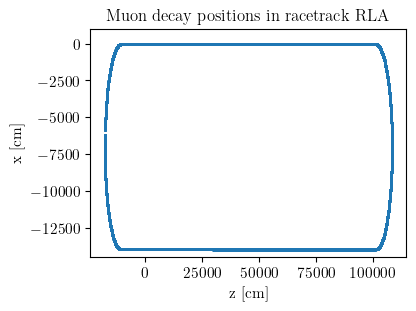

In [29]:
racetrack_RLA_numu.place_muons_on_lattice(lattice=racetrack_RLA, direction="clockwise")

fig, ax = pt.std_fig(figsize=(4, 3))
#ax.scatter(racetrack_RLA.vertices[0], racetrack_RLA.vertices[1], c='black', marker='+', s=10)
ax.scatter(racetrack_RLA_numu.pos['z'], racetrack_RLA_numu.pos['x'], marker='.', s=0.5)
#fig.gca().set_aspect('equal', adjustable='box')
ax.set_ylim(-145e2,10e2)
ax.set_xlabel("z [cm]")
ax.set_ylabel("x [cm]")
ax.set_title("Muon decay positions in racetrack RLA")

At a given detecct loc, # of nu events per time
(1 with beam dynamics) *expect to be gaussian
(1 w/o bd) * muon decay